# QClus Tutorial

This tutorial goes over the basic usage of the QClus package. It is assumed that you have already installed the package and its dependencies. If not, please refer to the installation instructions. More detailed tutorials covering special cases will be added in the future.

We begin by importing necessary libraries.

In [3]:
import sys
sys.path.append('..')

import qclus as qc
from qclus.gene_lists import *
from qclus.utils import *
import scanpy as sc
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

[autoreload of qclus.utils failed: Traceback (most recent call last):
  File "/opt/miniconda3/envs/scrna/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/opt/miniconda3/envs/scrna/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/opt/miniconda3/envs/scrna/lib/python3.12/importlib/__init__.py", line 131, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 995, in exec_module
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/Users/johannesojanen/Library/CloudStorage/GoogleDrive-johannes.ojanen@gmail.com/My Drive/WORK/Research/QClus/qclus/tutorials/../qclus/utils.py", line 6, in <module>
    import pysam
ModuleNotFoundError: No module named 'pysam'
]


In [ ]:
outs_directory = "scCAD/bam_files/66_outs"
specific_barcodes = ['AAACCCAAGACATAGT-1', 'AAACCCAAGACGTCGA-1', 'AAACCCAAGAGATCGC-1']

In [ ]:
nf = nuclear_fraction_tags(outs=outs_directory, 
                           verbose=True, 
                           tiles=80, 
                           cores=8)

Processing BAM tiles:   0%|                                                                                                                                                                                                     | 0/263 [00:00<?, ?tile/s]

In [ ]:
nf

CB
AAACCCAAGACATAGT-1    0.314339
AAACCCAAGACGTCGA-1    0.419696
AAACCCAAGAGATCGC-1    0.424808
AAACCCAAGATTAGCA-1    0.582882
AAACCCAAGCAACCAG-1    0.694962
                        ...   
TTTGTTGTCGTCCATC-1    0.264729
TTTGTTGTCTAACGGT-1    0.384692
TTTGTTGTCTACTGAG-1    0.460461
TTTGTTGTCTCTCTAA-1    0.334549
TTTGTTGTCTCTGCTG-1    0.304164
Name: nuclear_fraction, Length: 42812, dtype: float64

QClus requires two files to run: a Cell Ranger generated filtered count matrix and a Velocyto generated loom file. 

Detailed instructions on how to generate the loom file can be found in the [Velocyto documentation](http://velocyto.org/velocyto.py/tutorial/cli.html#running-velocyto-on-10x-data).

In [3]:
counts_path = "../../samples/filtered_feature_bc_matrix_CB-S00.h5"
loompy_path = "../../samples/counts_counts_CAD_CB-S00.loom"

Now we can run the main function of QClus. In this example, the only modification to the default settings we use is to select only clusters 0 and 1. All other keyword arguments are still listed blow with their respective default values to show all adjustable parameters of the algorithm.

Depending on the size of the sample this function can from seconds to a few minutes to run.

In [4]:


adata = qclus.run_qclus(counts_path, 
                        loompy_path, 
                        gene_set_dict=celltype_gene_set_dict,           # exact gene sets can be found in gene_lists.py
                        nucl_gene_set=nucl_genes_50,                    # exact gene set can be found in gene_lists.py
                        minimum_genes=500,                              # minimum number of detected genes allowed in droplet
                        maximum_genes=6000,                             # maximum number of detected genes allowed in droplet
                        max_mito_perc=40,                               # maximum percentage of mitochondrial content allowed in droplet
                        clustering_features=['pct_counts_nonCM',        # Clustering features as defined in publication
                                        'pct_counts_nucl_30',           
                                        'pct_counts_MT',            
                                        'pct_counts_CM_cyto', 
                                        'pct_counts_CM_nucl', 
                                        'fraction_unspliced'], 
                        clustering_k=4,                                 # number of clusters to generate
                        clusters_to_select=["0", "1"],                  # which clusters, in order of quality, to select
                        scrublet_filter=True,                           # whether or not to apply the Scrublet algorith,
                        scrublet_expected_rate=0.06,                    
                        scrublet_minimum_counts=2,                      
                        scrublet_minimum_cells=3,                       
                        scrublet_minimum_gene_variability_pctl=85,      
                        scrublet_n_pcs=30,                              
                        scrublet_thresh=0.1,                            
                        outlier_filter=True,                            # whether or not to apply outlier filter
                        outlier_unspliced_diff=0.1,                     # outlier filter setting
                        outlier_mito_diff=5)                            # outlier filter setting

We now have an AnnData object with raw counts and the QClus results in the .obs dataframe.

In [5]:
adata

AnnData object with n_obs × n_vars = 31670 × 36601
    obs: 'fraction_unspliced', 'pct_counts_MT', 'total_counts', 'n_genes_by_counts', 'qclus'
    var: 'gene_ids', 'feature_types', 'genome'

We can easily se which droplets passed and which got tagged for removal by which filtering step.

In [6]:
adata.obs.qclus.value_counts()

clustering filter    17581
passed                8628
scrublet filter       3982
outlier filter        1356
initial filter         123
Name: qclus, dtype: int64

In this case, 8628 droplets pass the filtering. Let's visualize the results on a UMAP.

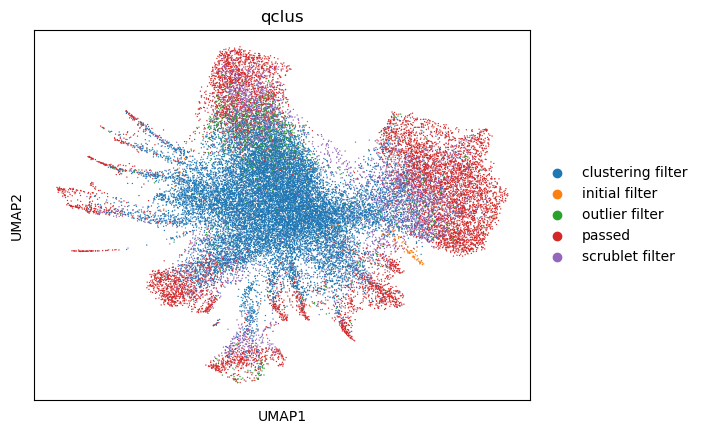

In [7]:
#run standard processing for visualization purposes
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

#save raw dataset and filter genes
adata.raw = adata
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.filter_genes(adata, min_cells=10)
adata = adata[:, adata.var.highly_variable]

sc.pp.regress_out(adata, ['total_counts', 'pct_counts_MT'], n_jobs = 30)
sc.pp.scale(adata, max_value=10)

sc.tl.pca(adata, svd_solver='randomized')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="leiden")

sc.pl.umap(adata, color="qclus")

We can now slect the barcodes that did not get flagged by one of the QClus steps with the following command.

In [8]:
adata = adata[adata.obs.qclus=="passed"]
adata

View of AnnData object with n_obs × n_vars = 8628 × 2745
    obs: 'fraction_unspliced', 'pct_counts_MT', 'total_counts', 'n_genes_by_counts', 'qclus', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'qclus_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

Let's redo the previous UMAP visualization to show the improvement in cell type seperation.

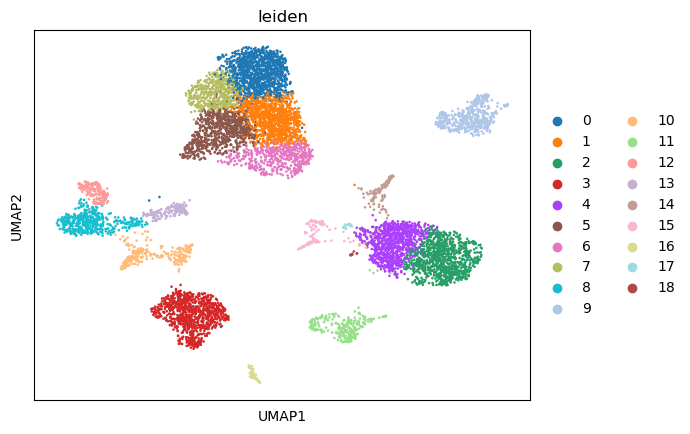

In [9]:
sc.tl.pca(adata, svd_solver='randomized')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="leiden")

sc.pl.umap(adata, color="leiden")